In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pyimzml
import re
import ntpath
from pyimzml.ImzMLParser import ImzMLParser as imp
from commons.data_processing import get_files, find_nearest, mass_error
from ntpath import basename, splitext
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [75]:
# get all data files
data_directory = '.\Data\subset_12'
all_imzml = get_files(data_directory, exts=['.imzML'])

# sort into hipocampus and hypothalamus
hipo_imzml = [file for file in all_imzml if re.search('hippocampus', file)]
hypo_imzml = [file for file in all_imzml if re.search('hypothalamus', file)]

In [76]:
# create a dictionary that maps mouse id to experimental condition
mouse_map = {}
for tissue in [hipo_imzml, hypo_imzml]:
    for file in tissue:
        name, _  = ntpath.splitext(ntpath.basename(file))
        name = name.split('_')
        group, ident = name[0], name[1]
        alias = '-'.join([group, ident])
        mouse_map[alias] = mouse_map.get(alias, group)

# create a map to give unique values to each experimental condition
group_map = {
    i:v for (i,v) in zip(list(set(mouse_map.values())), range(1,5))
}
group_map_rev = {
    i:v for (i,v) in zip(range(1,5), list(set(mouse_map.values())))
}

In [77]:
# create parser objects for each file
# these parser objects are just 'read' versions of the data, this will reduce
# the time needed to execute following code

hipo_parsers = {}
for file in hipo_imzml:
    spl = ntpath.basename(file).split('_')
    ident = '-'.join(spl[:2])
    parser = imp(file)
    hipo_parsers[ident] = parser

hypo_parsers = {}
for file in hypo_imzml:
    spl = ntpath.basename(file).split('_')
    ident = '-'.join(spl[:2])
    parser = imp(file)
    hypo_parsers[ident] = parser

C:\Users\Graham Delafield\AppData\Local\Programs\Python\Python38\lib\site-packages\pyimzml\ontology\ontology.py:86: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".



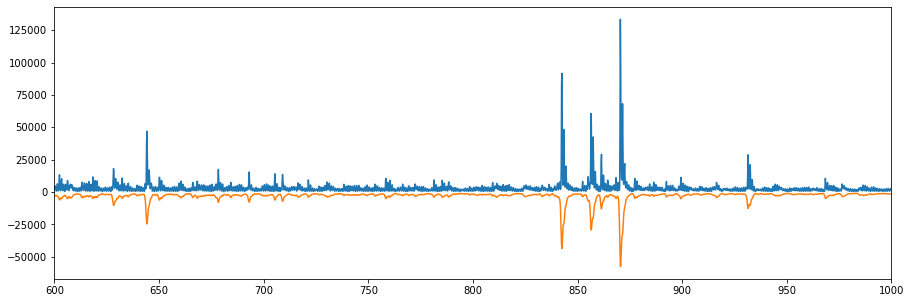

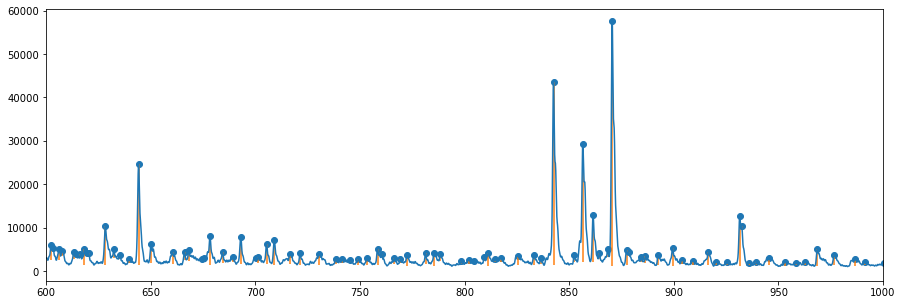

In [78]:

hipo_x_global = np.zeros(hipo_parsers['kc-1'].getspectrum(0)[0].shape)
hipo_y_global = np.zeros(hipo_parsers['kc-1'].getspectrum(0)[0].shape)


for parser in hipo_parsers.values():
    for i, _ in enumerate(parser.coordinates):
        x, y = parser.getspectrum(i)
        hipo_x_global = x 
        hipo_y_global += y

smooth_y = gaussian_filter(hipo_y_global, sigma=2)

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(hipo_x_global, hipo_y_global)
plt.plot(hipo_x_global, smooth_y * -1)
plt.xlim(600, 1000)

fig, ax = plt.subplots(figsize=(15, 5))
peaks, d = find_peaks(smooth_y, prominence=500)
ax.plot(hipo_x_global, smooth_y)
ax.scatter(hipo_x_global[peaks], smooth_y[peaks])
ax.vlines(x=hipo_x_global[peaks], ymin=smooth_y[peaks] - d["prominences"],
           ymax = smooth_y[peaks], color = "C1")
ax.set_xlim(600, 1000)

hipo_masses = hipo_x_global[peaks]
sort_peaks = sorted(peaks, key = lambda x: smooth_y[x], reverse=True)

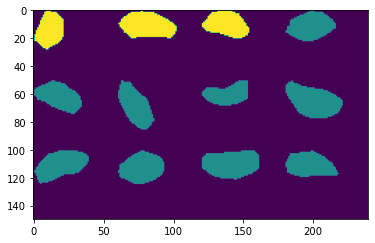

In [79]:
def make_grid(parsers, map=None, group=None):

    if group is not None:
        group_colors = dict(zip(group, range(2, len(group)+2)))

    y_dim = 50
    x_dim = 60
    GRID_X = 4
    GRID_Y = 3

    tissue_grid = np.zeros(shape=(y_dim * GRID_Y, x_dim * GRID_X))

    for i, (mouse, tissue) in enumerate(parsers.items()):

        # determine on which pixel to start
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
            
        for _, coordinate in enumerate(tissue.coordinates):
            if group is None or map[mouse] not in group:
                val = 1
            elif map[mouse] in group:
                val = group_colors[map[mouse]]
            
            tissue_grid[start_y + coordinate[1], start_x + coordinate[0]] = val

    return tissue_grid

m = make_grid(hipo_parsers, map=mouse_map, group=['kc'])
plt.imshow(m)

In [80]:
data_sheet = r'./Data/193 peak 03132022.csv'
import pandas as pd
df = pd.read_csv(data_sheet, skiprows=range(8))
df.columns = ['mass', 'interval_da']

potential_matches = df.mass.to_numpy()

In [81]:
y_dim = 50
x_dim = 60

GRID_X = 4
GRID_Y = 3


hipo_array_data = []
mask = make_grid(hipo_parsers)
for mass in potential_matches:
    grid = np.zeros(shape=(y_dim * GRID_Y, x_dim * GRID_X))
    for i, tissue in enumerate(hipo_parsers.values()):
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
        im = pyimzml.ImzMLParser.getionimage(tissue, mass, 100)
        shape = im.shape

        grid[start_y:start_y+shape[0], start_x:start_x+shape[1]] = im
    hipo_array_data.append(grid[np.where(mask>0)])
print(len(hipo_array_data))
# set seed for reproducibility
np.random.seed(seed=0)

# transpose data to cluster by pixel
hipo_data = np.array(hipo_array_data).T

from sklearn.manifold import TSNE
# cluster data
hipo_X_embedded = TSNE(n_components=3, perplexity=25, n_iter=2000).fit_transform(hipo_data) # was 50 originally

193


In [82]:
mask = make_grid(hipo_parsers, map=mouse_map, group=['wc', 'kc', 'ws', 'ks'])
groups = mask[np.where(mask > 0)]
group_labels = [group_map_rev[i-1] for i in groups]

import pandas as pd
hipo_d3 = pd.DataFrame({
    'tSNE_1': hipo_X_embedded[:,0],
    'tSNE_2': hipo_X_embedded[:,1],
    'tSNE_3': hipo_X_embedded[:,2],
    'Treatment Group': group_labels
})


hipo_d3 = hipo_d3[hipo_d3['tSNE_1'] < 60]

import plotly.express as px

fig = px.scatter_3d(
    hipo_d3,
    x='tSNE_1', y='tSNE_2',
    z='tSNE_3',
    color='Treatment Group',
    color_discrete_sequence=[
        "#F5B8D3", # pink
        "#96D1AD", # green
        "#92AFDB", # blue
        "#FECA6D", # yellow
        ],
    width=800, height=800,
)

fig.update_traces(marker=dict(size=5,
                              opacity=1,
                              line=dict(width=0.001,
                                        color='#565656')),
                  selector=dict(mode='markers'))

fig.update_layout(legend= {'itemsizing': 'constant'})

fig.update_layout(
    title={
        'text': "Hippocampus",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.write_html("./figures/Interactive/Hippocampus_tSNE.html")
fig.show()

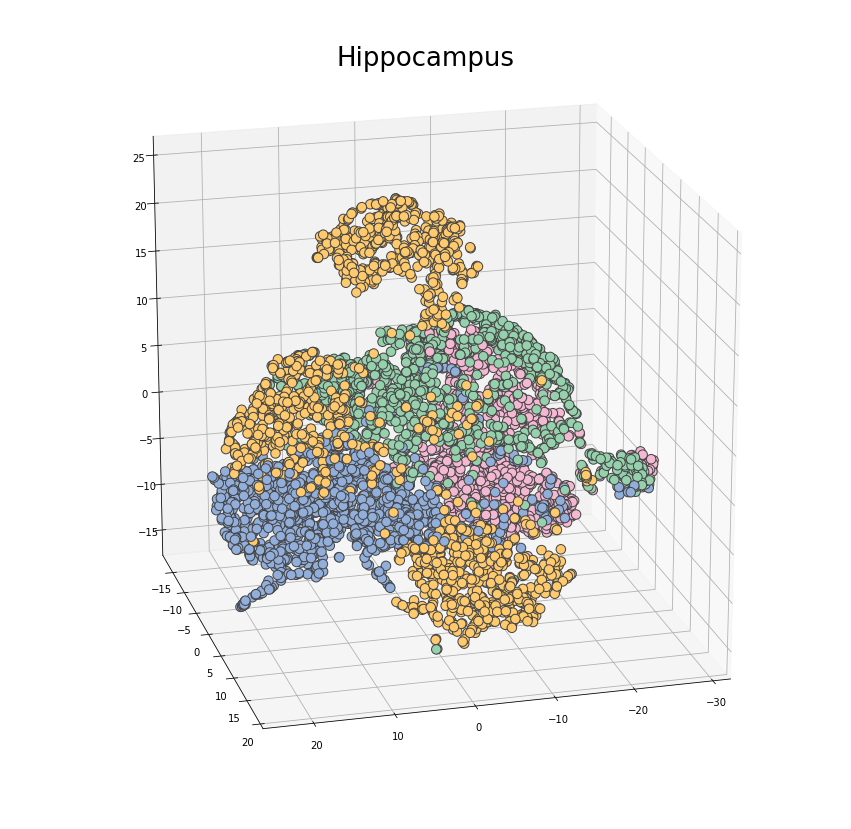

In [83]:
groups = hipo_d3['Treatment Group']
# group_labels = [group_map_rev[i] for i in groups]

color_map = {
    'wc':'#96D1AD',
    'ws':'#FECA6D',
    'ks':'#F5B8D3',
    'kc':'#92AFDB'
}

colors = [color_map[g] for g in groups]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
s = ax.scatter(hipo_d3['tSNE_3'], hipo_d3['tSNE_2'], hipo_d3['tSNE_1'], c=colors, s=90, edgecolors='#444444')
s.set_edgecolors = s.set_facecolors = lambda *args:None
ax.view_init(20, 75)
plt.title('Hippocampus', fontsize=26)
plt.savefig('./figures/Hippocampus_3d.svg')
plt.show()

In [84]:
y_dim = 50
x_dim = 60

GRID_X = 4
GRID_Y = 3


hypo_array_data = []
mask = make_grid(hypo_parsers)
for mass in potential_matches:
    grid = np.zeros(shape=(y_dim * GRID_Y, x_dim * GRID_X))
    for i, tissue in enumerate(hypo_parsers.values()):
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
        im = pyimzml.ImzMLParser.getionimage(tissue, mass, 100)
        shape = im.shape

        grid[start_y:start_y+shape[0], start_x:start_x+shape[1]] = im
    hypo_array_data.append(grid[np.where(mask>0)])
print(len(hypo_array_data))
# set seed for reproducibility
np.random.seed(seed=0)

# transpose data to cluster by pixel
hypo_data = np.array(hypo_array_data).T

from sklearn.manifold import TSNE
# cluster data
hypo_X_embedded = TSNE(n_components=3, perplexity=25, n_iter=2000).fit_transform(hypo_data) # was 50 originally

193


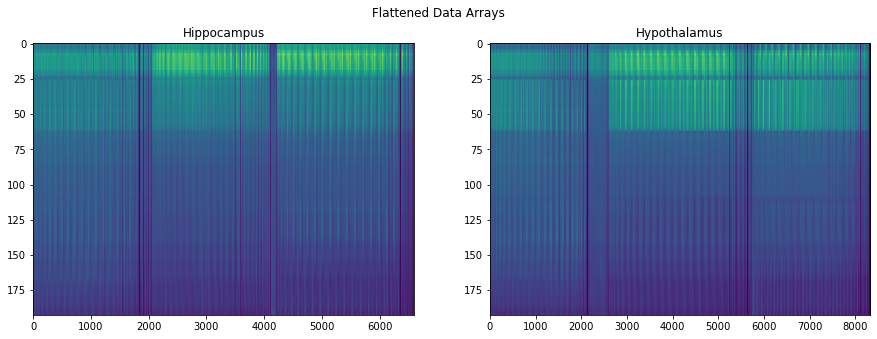

In [85]:
mask = make_grid(hypo_parsers, map=mouse_map, group=['wc', 'kc', 'ws', 'ks'])
groups = mask[np.where(mask > 0)]
group_labels = [group_map_rev[i-1] for i in groups]

import pandas as pd
hypo_d3 = pd.DataFrame({
    'tSNE_1': hypo_X_embedded[:,0],
    'tSNE_2': hypo_X_embedded[:,1],
    'tSNE_3': hypo_X_embedded[:,2],
    'Treatment Group': group_labels
})


hypo_d3 = hypo_d3[hypo_d3['tSNE_2'] > -60]

import plotly.express as px

fig = px.scatter_3d(
    hypo_d3,
    x='tSNE_1', y='tSNE_2',
    z='tSNE_3',
    color='Treatment Group',
    color_discrete_sequence=[
        "#F5B8D3", # pink
        "#96D1AD", # green
        "#92AFDB", # blue
        "#FECA6D", # yellow
        ],
    width=800, height=800,
)

fig.update_traces(marker=dict(size=5,
                              opacity=1,
                              line=dict(width=0.001,
                                        color='#565656')),
                  selector=dict(mode='markers'))

fig.update_layout(legend= {'itemsizing': 'constant'})

fig.update_layout(
    title={
        'text': "Hypothalamus",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.write_html("./figures/Interactive/Hypothalamus_tSNE.html")
fig.show()

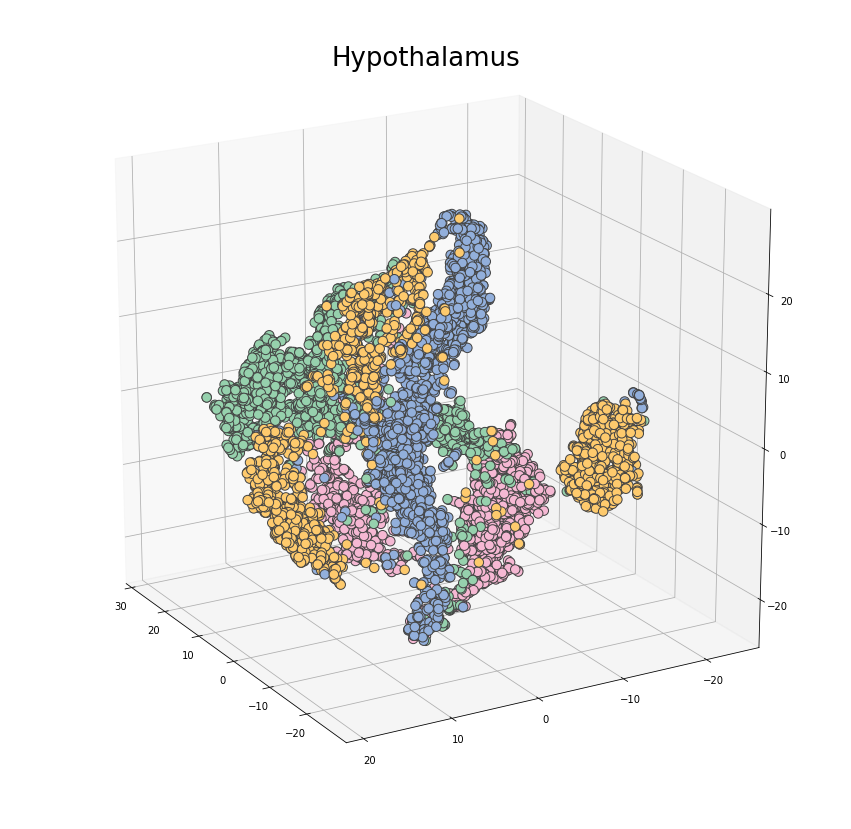

In [86]:
groups = hypo_d3['Treatment Group']
# group_labels = [group_map_rev[i] for i in groups]

color_map = {
    'wc':'#96D1AD',
    'ws':'#FECA6D',
    'ks':'#F5B8D3',
    'kc':'#92AFDB'
}

colors = [color_map[g] for g in hypo_d3['Treatment Group']]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
s = ax.scatter(hypo_d3['tSNE_3'], hypo_d3['tSNE_2'], hypo_d3['tSNE_1'], c=colors, s=90, edgecolors='#444444')
s.set_edgecolors = s.set_facecolors = lambda *args:None
ax.view_init(20, 150)
plt.title('Hypothalamus', fontsize=26)
plt.savefig('./figures/Hypothalamus_tSNE.svg')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(hspace=1)

axs[0].imshow(hipo_data.T, aspect='auto')
axs[0].set_title('Hippocampus')
axs[1].imshow(hypo_data.T, aspect='auto')
axs[1].set_title('Hypothalamus')
plt.suptitle('Flattened Data Arrays')

fig = plt.gcf()
fig.savefig('./Figures/flattened_data_arrays.png')
fig.savefig('./Figures/flattened_data_arrays.svg')
plt.show()